# Black Vault Scraping and Data Analysis Notebook

This notebook contains code for scraping documents from The Black Vault website and then cleaning/preparing the data for analysis.The aim of this project is to analyze and summarize declassified UFO-related content from The Black Vault, a website known for publishing government documents obtained through FOIA (Freedom of Information Act) requests. By web scraping and categorizing this content, the project seeks to uncover trends in how the U.S. government communicates about UFOs and related programs like AATIP. It focuses on identifying patterns in sentiment, document types, key topics (e.g., whistleblowers, debunkings), and shifts in official narratives over time. Ultimately, the goal is to better understand the transparency, tone, and thematic focus of official UFO-related disclosures.

# Legality

Can be checked from this link:

https://www.theblackvault.com/robots.txt

Mikita Silivestrau -​ ms392905​

Dilara Ozdil - 474544​

In [2]:
!pip install pandas numpy selenium

  Using cached trio-0.29.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached trio_websocket-0.12.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached outcome-1.3.0.post0-py2.py3-none-any.whl.metadata (2.6 kB)
  Using cached wsproto-1.2.0-py3-none-any.whl.metadata (5.6 kB)
   ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.4 MB 330.3 kB/s eta 0:00:29
   ---------------------------------------- 0.1/9.4 MB 469.7 kB/s eta 0:00:20
   ---------------------------------------- 0.1/9.4 MB 595.3 kB/s eta 0:00:16
    --------------------------------------- 0.2/9.4 MB 701.4 kB/s eta 0:00:14
    --------------------------------------- 0.2/9.4 MB 737.3 kB/s eta 0:00:13
   - -------------------------------------- 0.2/9.4 MB 754.9 kB/s eta

In [5]:
!pip install textblob


   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
    --------------------------------------- 10.2/624.3 kB ? eta -:--:--
   - ------------------------------------- 20.5/624.3 kB 330.3 kB/s eta 0:00:02
   -- ------------------------------------ 41.0/624.3 kB 393.8 kB/s eta 0:00:02
   ---- ---------------------------------- 71.7/624.3 kB 435.7 kB/s eta 0:00:02
   ------ ------------------------------- 102.4/624.3 kB 535.8 kB/s eta 0:00:01
   ------- ------------------------------ 122.9/624.3 kB 514.3 kB/s eta 0:00:01
   --------- ---------------------------- 153.6/624.3 kB 538.9 kB/s eta 0:00:01
   ----------- -------------------------- 184.3/624.3 kB 556.2 kB/s eta 0:00:01
   ------------- ------------------------ 225.3/624.3 kB 597.3 kB/s eta 0:00:01
   --------------- ---------------------- 256.0/624.3 kB 605.3 kB/s eta 0:00:01
   ---------------- --------------------- 266.2/624.3 kB 584.5 kB/s eta 0:00:01
   ------------------ ------------------- 307.2/624.3 kB 

# 1. Importing Libraries

OS operations (os)

CSV handling (csv)

Time delays (time, random)

Regular expressions (re)

Logging (logging)

Web scraping & automation (selenium.webdriver)

Parsing HTML (BeautifulSoup)

Data handling (pandas, numpy)

Text processing (TextBlob)

In [2]:
# Imports
import os
import csv
import time
import random
import re
import logging
from datetime import datetime

import pandas as pd
import numpy as np

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from bs4 import BeautifulSoup

from textblob import TextBlob


##  2. Scraping Functions



### Logging Setup and Creating a Data Directory

-Logging setup: Allows tracking of script execution.

-INFO level: Shows informational messages, warnings, and errors.

-Format: Logs include timestamp, log level (INFO, ERROR), and message.

-Checks if the data/ directory exists in the current working directory (script_dir).

-Creates the directory if it doesn’t exist.



In [3]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def create_data_directory():
    """Create data directory if it doesn't exist."""
    if not os.path.exists("data"):
        os.makedirs("data")
        logger.info("Created data directory")


### Setting Up Chrome WebDriver

Configures Selenium's Chrome WebDriver with options:

--start-maximized → Opens browser in full screen.

--no-sandbox & --disable-dev-shm-usage → Helps in headless environments.

--disable-gpu → Avoids issues on some systems.

User-Agent → Pretends to be a real browser to avoid detection.

Finds Chrome's location on Windows.

Launches WebDriver and returns it.

In [4]:

def setup_driver():
    """Setup and return a configured Chrome WebDriver."""
    logger.info("Setting up Chrome WebDriver...")
    chrome_options = Options()
    chrome_options.add_argument('--start-maximized')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) ' +
                                'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36')
    
    try:
        # Try to find Chrome in common Windows locations
        chrome_paths = [
            r"C:\Program Files\Google\Chrome\Application\chrome.exe",
            r"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe",
            os.environ.get("PROGRAMFILES", "") + r"\Google\Chrome\Application\chrome.exe",
            os.environ.get("PROGRAMFILES(X86)", "") + r"\Google\Chrome\Application\chrome.exe",
        ]
        
        chrome_binary = None
        for path in chrome_paths:
            if os.path.exists(path):
                chrome_binary = path
                break
        
        if chrome_binary:
            chrome_options.binary_location = chrome_binary
            logger.info(f"Found Chrome at: {chrome_binary}")
        
        # Use the default ChromeDriver that comes with Selenium
        driver = webdriver.Chrome(options=chrome_options)
        logger.info("Chrome WebDriver setup successful")
        return driver
    except Exception as e:
        logger.error(f"Error creating Chrome WebDriver: {e}")
        raise


### Waiting for Elements to Load



In [5]:
def wait_for_element(driver, by, value, timeout=10):
    """Wait for an element to be visible."""
    WebDriverWait(driver, timeout).until(EC.visibility_of_element_located((by, value)))
    time.sleep(0.5)

### Handling Cookie Consent Popups

Tries clicking multiple possible cookie consent buttons using CSS selectors.

If found, clicks the button and proceeds.

In [6]:
def handle_cookie_consent(driver):
    """Handle the cookie consent popup."""
    try:
        selectors = [
            'button.Consent',
            'button.fc-button.fc-cta-consent',
            '.fc-button-label'
        ]
        
        for selector in selectors:
            try:
                wait = WebDriverWait(driver, 5)
                element = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, selector)))
                driver.execute_script("arguments[0].click();", element)
                time.sleep(1)
                return True
            except:
                continue
        
        return False
        
    except Exception as e:
        print(f"Error in cookie consent handling: {str(e)}")
        return False

### Text Cleaning (Sanitization)

Removes:

-Newlines and semicolons (prevents CSV formatting issues).

-Extra spaces.

-Non-ASCII characters (fixes encoding errors).

In [7]:
def sanitize_text(text):
    """Sanitize text by removing problematic characters."""
    if not isinstance(text, str):
        return ''
    text = re.sub(r'[\n\r;]', ' ', text)  # Replace newlines, carriage returns, and semicolons
    text = re.sub(r'\s+', ' ', text)         # Replace multiple spaces with a single space
    text = re.sub(r'[^\x20-\x7E]', '', text)  # Remove non-ASCII characters
    return text.strip()

### Extracting Document Data

-Navigates to a document page.

-Extracts the document title.

-Extracts publication date from metadata.

-Finds the main content inside article.

-Sanitizes the extracted data.

-Returns the document’s title, date, content, and URL.

In [8]:
def extract_document_data(driver, url):
    """Extract data from a document page."""
    try:
        driver.get(url)
        wait_for_element(driver, By.CSS_SELECTOR, 'article')
        
        # Extract title from page title
        page_title = driver.title
        if page_title and " - The Black Vault" in page_title:
            title = page_title.replace(" - The Black Vault", "").strip()
        else:
            title = ''
        
        # Extract date from meta tag
        try:
            date_element = driver.find_element(By.CSS_SELECTOR, 'meta[property="article:published_time"]')
            date = date_element.get_attribute('content')
            if date:
                date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S%z").strftime("%Y-%m-%d")
        except:
            date = ''
        
        # Extract content from article
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        article = soup.find('article')
        
        if article:
            content_div = article.find('div', class_='entry-content')
            if content_div:
                content_text = content_div.get_text()
                archive_index = content_text.find('Document Archive')
                if archive_index != -1:
                    content_text = content_text[:archive_index].strip()
                content = re.sub(r'\s+', ' ', content_text)
            else:
                content = ''
            
            # Sanitize fields
            title = sanitize_text(title)
            content = sanitize_text(content)
            url = sanitize_text(url)
            
            return {
                'title': title,
                'date': date,
                'content': content,
                'url': url
            }
    except Exception as e:
        print(f"Error extracting document data: {e}")
        return None

### Generating a Unique File Name

Creates a filename using the current timestamp and process ID.

Ensures each file has a unique name.



In [9]:
def create_unique_filename():
    """Create a unique filename with timestamp and process ID."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    process_id = os.getpid()
    filename = f"black_vault_ufo_{timestamp}_{process_id}.csv"
    filepath = os.path.join("data", filename)
    return filepath

### Main Scraping Function

This is the core function that:

-Creates the data directory.

-Initializes the WebDriver.

-Navigates to the UFO document archive.

-Handles cookies.

-Extracts document links from multiple pages.

-Scrapes data from each document page.

-Saves data to a CSV file.

In [11]:
def scrape_black_vault():
    """Scrape documents from The Black Vault's UFO Phenomena category."""
    logger.info("Starting Black Vault scraping process...")
    create_data_directory()
    start_time = time.time()
    documents = []
    current_page = 1
    target_documents = 30  # Adjust target as needed
    driver = None
    
    try:
        logger.info("Setting up Chrome WebDriver...")
        driver = setup_driver()
        if not driver:
            raise Exception("Failed to initialize Chrome WebDriver")
        
        base_url = "https://www.theblackvault.com/documentarchive/category/the-fringe/ufo-phenomena/"
        logger.info(f"Navigating to {base_url}")
        driver.get(base_url)
        
        logger.info("Waiting for initial page load...")
        time.sleep(3)
        
        handle_cookie_consent(driver)
        wait_for_element(driver, By.CSS_SELECTOR, 'article')
        
        while len(documents) < target_documents:
            try:
                soup = BeautifulSoup(driver.page_source, 'html.parser')
                articles = soup.find_all('article')
                
                total_articles = len(articles)
                logger.info(f"Found {total_articles} documents on page {current_page}")
                logger.info(f"Total documents collected so far: {len(documents)}/{target_documents}")
                
                for i, article in enumerate(articles, 1):
                    if len(documents) >= target_documents:
                        logger.info(f"Reached target of {target_documents} articles. Finishing...")
                        break
                    
                    logger.info(f"Processing document {i}/{total_articles} (Total: {len(documents)+1}/{target_documents})")
                    link = article.find('a')['href']
                    doc_data = extract_document_data(driver, link)
                    if doc_data:
                        documents.append(doc_data)
                        logger.info(f"Successfully collected document {len(documents)}")
                    time.sleep(0.5)
                
                if len(documents) < target_documents:
                    current_page += 1
                    next_url = f"{base_url}page/{current_page}/"
                    logger.info(f"Navigating to page {current_page}...")
                    driver.get(next_url)
                    time.sleep(2)
                    wait_for_element(driver, By.CSS_SELECTOR, 'article')
                
            except Exception as e:
                logger.error(f"Error processing page {current_page}: {e}")
                break
        
        if documents:
            df = pd.DataFrame(documents)
            df.columns = ['title', 'date', 'content', 'url']
            for col in ['title', 'content', 'url']:
                df[col] = df[col].apply(lambda x: re.sub(r'[\n\r]+', ' ', x))
            output_file = create_unique_filename()
            df.to_csv(output_file, 
                     index=False, 
                     sep=';', 
                     quoting=csv.QUOTE_ALL, 
                     quotechar='"', 
                     doublequote=True,
                     encoding='utf-8')
            logger.info(f"Successfully saved {len(documents)} documents to {output_file}")
        
    except Exception as e:
        logger.error(f"An error occurred: {e}")
        raise
    finally:
        if driver:
            try:
                logger.info("Closing Chrome WebDriver...")
                driver.quit()
            except Exception as e:
                logger.error(f"Error closing Chrome WebDriver: {e}")
                
        #track and print the execution time 
        end_time = time.time()  
        duration = end_time - start_time
        logger.info(f"Scraping process completed in {duration:.2f} seconds.")
        return documents

# In a notebook, the __name__ block will not auto-run. To execute scraping, run the function directly.
# For example, uncomment the line below to run the scraping process (ensure you have the proper WebDriver set up):
# scrape_black_vault()

In [12]:
documents = scrape_black_vault()


2025-04-05 11:55:07,625 - INFO - Starting Black Vault scraping process...
2025-04-05 11:55:07,629 - INFO - Setting up Chrome WebDriver...
2025-04-05 11:55:07,630 - INFO - Setting up Chrome WebDriver...
2025-04-05 11:55:07,637 - INFO - Found Chrome at: C:\Program Files\Google\Chrome\Application\chrome.exe
2025-04-05 11:55:12,748 - INFO - Chrome WebDriver setup successful
2025-04-05 11:55:12,753 - INFO - Navigating to https://www.theblackvault.com/documentarchive/category/the-fringe/ufo-phenomena/
2025-04-05 11:55:15,976 - INFO - Waiting for initial page load...
2025-04-05 11:55:26,946 - INFO - Found 5 documents on page 1
2025-04-05 11:55:26,948 - INFO - Total documents collected so far: 0/30
2025-04-05 11:55:26,955 - INFO - Processing document 1/5 (Total: 1/30)
2025-04-05 11:55:41,128 - INFO - Successfully collected document 1
2025-04-05 11:55:41,631 - INFO - Processing document 2/5 (Total: 2/30)
2025-04-05 11:55:48,604 - INFO - Successfully collected document 2
2025-04-05 11:55:49,108 

## 3.Data Preparation Functions

The next cells defines functions to clean and prepare the scraped data for further analysis.

### clean_text(text)

-Cleans and normalizes text by removing punctuation, numbers, and excessive whitespace.

-Converts text to lowercase.

-Removes special characters and punctuation.

-Removes extra spaces.

-Removes numbers.

-Strips leading and trailing spaces.

In [13]:
def clean_text(text):
    """Clean and normalize text content."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

### count_words(text)

-Counts the number of words in the cleaned text.

-Splits the cleaned text into words.

-Returns the count.

-Show in bar chart.


In [14]:
def count_words(text):
    """Count words in cleaned text."""
    if not isinstance(text, str):
        return 0
    return len(text.split())

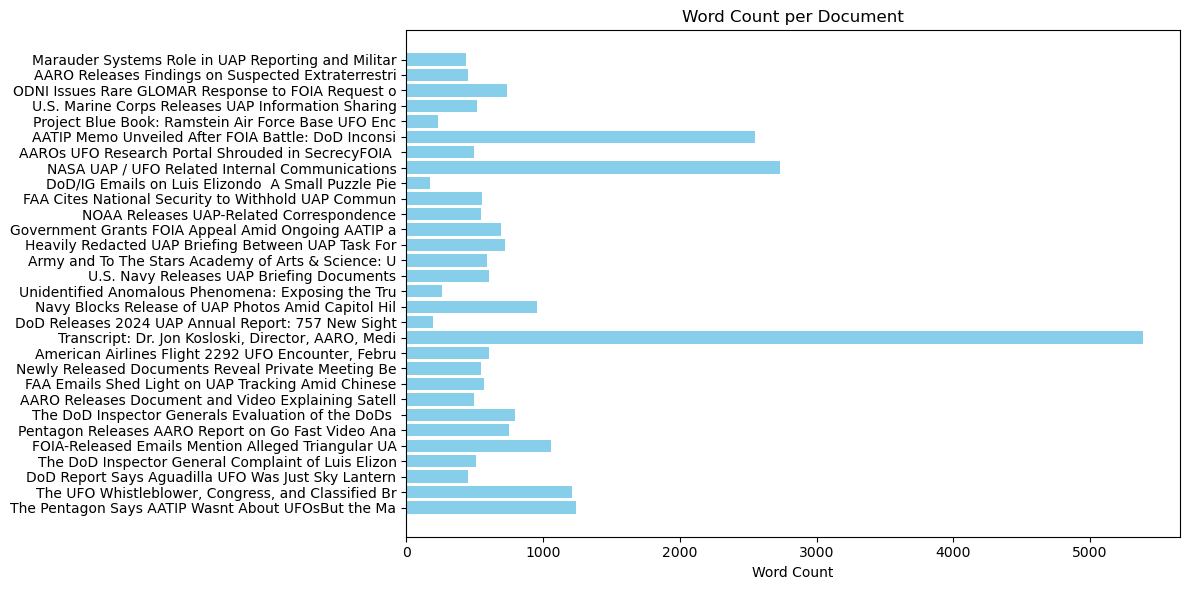

In [15]:
import matplotlib.pyplot as plt

# Your word count function
def count_words(text):
    if not isinstance(text, str):
        return 0
    return len(text.split())

# Generate word counts
titles = []
word_counts = []

for doc in documents:
    titles.append(doc['title'][:50])  # Truncate long titles
    word_counts.append(count_words(doc['content']))

# Create bar chart
plt.figure(figsize=(12, 6))
plt.barh(titles, word_counts, color='skyblue')
plt.xlabel('Word Count')
plt.title('Word Count per Document')
plt.tight_layout()
plt.show()


### analyze_sentiment(text)

-Uses TextBlob to determine the sentiment of the text.

-Calculates the polarity score:

    Positive if polarity > 0.1.

    Negative if polarity < -0.1.

    Neutral otherwise.

-Returns the sentiment classification.

In [16]:
def analyze_sentiment(text):
    """Analyze sentiment of text using TextBlob."""
    if not isinstance(text, str):
        return "Neutral"
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"
    


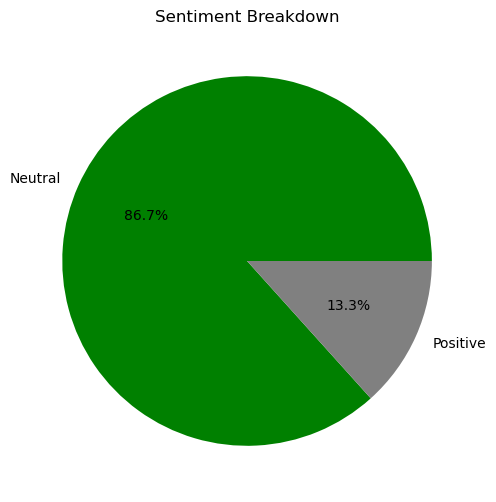

In [17]:
import matplotlib.pyplot as plt
from collections import Counter

# Apply sentiment analysis to each document
sentiments = [analyze_sentiment(doc['content']) for doc in documents]

# Count occurrences
sentiment_counts = Counter(sentiments)


    # Pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), 
        autopct='%1.1f%%', colors=['green', 'gray', 'red'])
plt.title("Sentiment Breakdown")
plt.show()

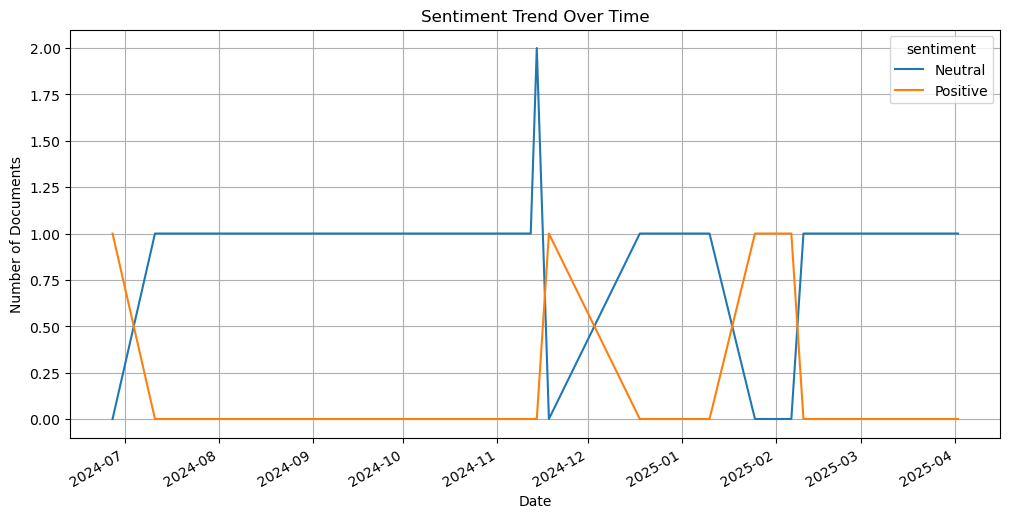

In [18]:
import pandas as pd

df = pd.DataFrame(documents)
df['sentiment'] = df['content'].apply(analyze_sentiment)

# Make sure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Count sentiment per day
timeline = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

# Plot timeline
timeline.plot(kind='line', figsize=(12, 6))
plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Documents")
plt.grid(True)
plt.show()


###  extract_categories(text)
 
-Categorizes documents based on keywords.

-Defines category groups (e.g., Government Report, Military Encounter, etc.).

-Counts occurrences of category-specific keywords in the text.

-Assigns the document to the most frequent category.

-If no category is found, labels it as "Uncategorized".

In [19]:
def extract_categories(text):
    """Extract categories from content text using keyword matching."""
    if not isinstance(text, str):
        return "Uncategorized"
    text = text.lower()
    categories = {
        'Government Report': ['government', 'report', 'official', 'department', 'agency', 'pentagon', 'dod', 'aaro'],
        'Military Encounter': ['military', 'navy', 'air force', 'pilot', 'aircraft', 'radar'],
        'UFO Sighting': ['sighting', 'witness', 'observed', 'spotted', 'seen'],
        'Document Release': ['document', 'release', 'declassified', 'foia', 'disclosure'],
        'Investigation': ['investigation', 'research', 'analysis', 'study', 'examined'],
        'Historical Case': ['historical', 'history', 'archive', 'past', 'year']
    }
    category_scores = {cat: 0 for cat in categories}
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in text:
                category_scores[category] += 1
    max_score = max(category_scores.values())
    if max_score == 0:
        return "Uncategorized"
    selected_categories = [cat for cat, score in category_scores.items() if score == max_score]
    return ', '.join(selected_categories)

In [20]:

categories = [extract_categories(doc['content']) for doc in documents]


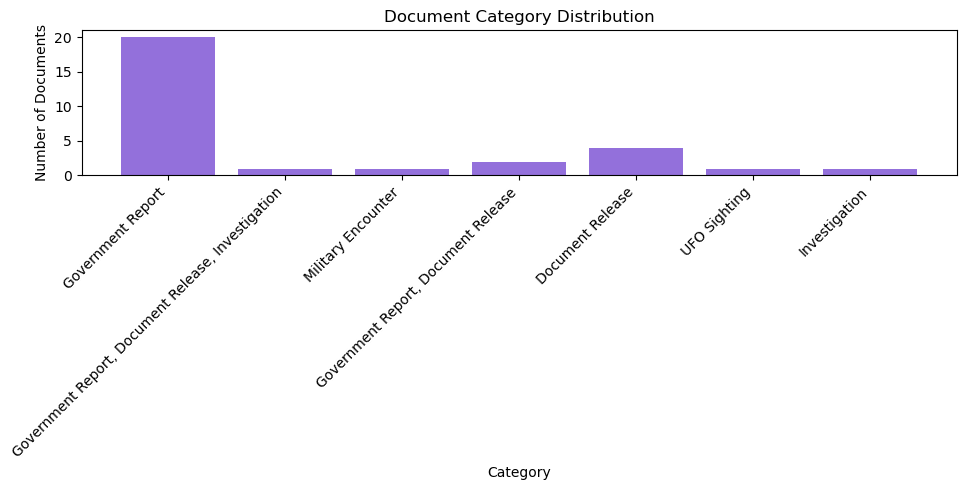

In [21]:
import matplotlib.pyplot as plt
from collections import Counter

# Count categories
category_counts = Counter(categories)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(category_counts.keys(), category_counts.values(), color='mediumpurple')
plt.xticks(rotation=45, ha='right')
plt.title("Document Category Distribution")
plt.xlabel("Category")
plt.ylabel("Number of Documents")
plt.tight_layout()
plt.show()


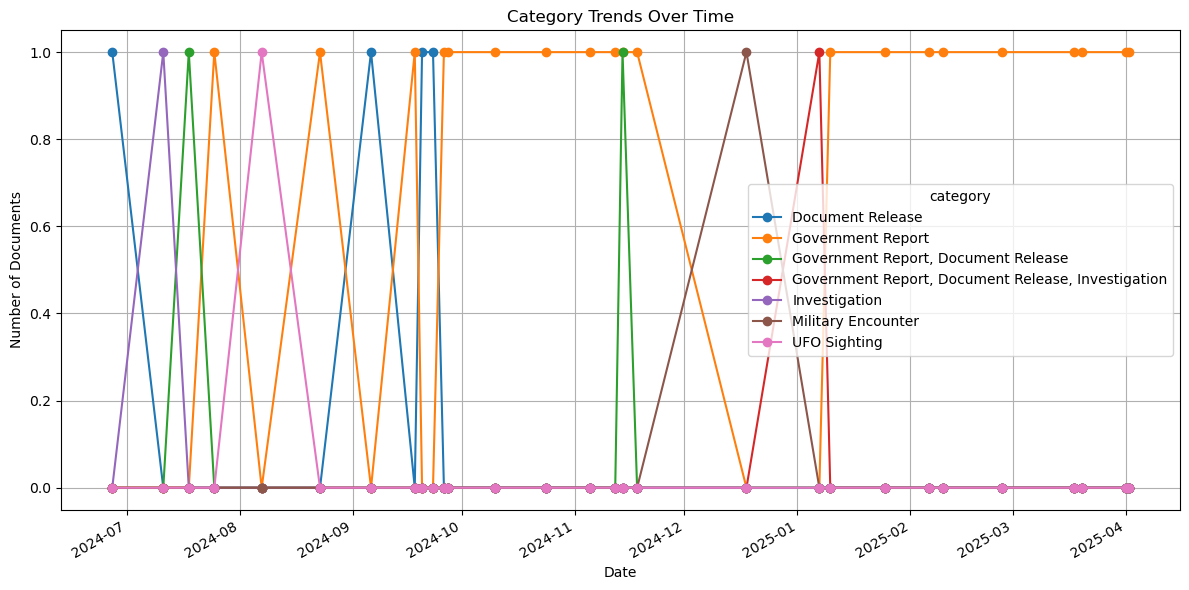

In [22]:
import pandas as pd

df = pd.DataFrame(documents)
df['category'] = df['content'].apply(extract_categories)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Group by date and category
timeline = df.groupby(['date', 'category']).size().unstack(fill_value=0)

# Plot timeline
timeline.plot(kind='line', figsize=(12, 6), marker='o')
plt.title("Category Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Documents")
plt.grid(True)
plt.tight_layout()
plt.show()


### prepare_data(input_file)


-Reads CSV (tries semicolon ; first, then falls back to comma ,).

-Cleans content: Uses clean_text().

-Extracts categories: Uses extract_categories().

-Counts words: Uses count_words().

-Analyzes sentiment: Uses analyze_sentiment().

-Formats the date.

-Creates output directory (data/ folder).

-Saves cleaned data to a CSV file.

-Prints summary statistics:

-Total documents.

-Average word count.

-Sentiment distribution.

-Category distribution.



In [29]:
def prepare_data(input_file):
    """Prepare scraped data for analysis."""
    print(f"Reading data from {input_file}...")
   
    try:
        df = pd.read_csv(input_file, delimiter=';', quoting=1)  # quoting=1 means QUOTE_ALL
        print("Successfully read CSV file with semicolon delimiter")
    except Exception as e:
        print(f"Error reading CSV with semicolon delimiter: {e}")
        print("Trying with comma delimiter...")
        try:
            df = pd.read_csv(input_file, quoting=1)
            print("Successfully read CSV file with comma delimiter")
        except Exception as e:
            print(f"Error reading CSV with comma delimiter: {e}")
            raise
    print("Cleaning and preparing data...")
    df['Content (cleaned)'] = df['content'].apply(clean_text)
    print("Cleaned content")
    df['Categories'] = df['content'].apply(extract_categories)
    print("Extracted categories")
    df['Word Count'] = df['Content (cleaned)'].apply(count_words)
    print("Counted words")
    df['Sentiment'] = df['Content (cleaned)'].apply(analyze_sentiment) 
    print("Analyzed sentiment")
    df['Date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
    print("Formatted dates")
    columns = ['title', 'Date', 'Content (cleaned)', 'Categories', 'url', 'Word Count', 'Sentiment']
    df_prepared = df[columns]
    df_prepared.columns = ['Title', 'Date', 'Content (cleaned)', 'Categories', 'URL', 'Word Count', 'Sentiment']
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    # In a notebook, __file__ is not defined so we use the current working directory
    script_dir = os.getcwd()
    data_dir = os.path.join(script_dir, 'data')
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        print(f"Created data directory at {data_dir}")
    output_file = os.path.join(data_dir, f'prepared_black_vault_ufo_{timestamp}.csv')
    df_prepared.to_csv(output_file, index=False, sep=';', quoting=1)
    print(f"\nPrepared data saved to {output_file}")
    print("\nSummary Statistics:")
    print(f"Total documents: {len(df_prepared)}")
    print(f"Average word count: {df_prepared['Word Count'].mean():.2f}")
    print("\nSentiment Distribution:")
    print(df_prepared['Sentiment'].value_counts())
    print("\nCategory Distribution:")
    print(df_prepared['Categories'].value_counts())
    return df_prepared

# Main script logic
if __name__ == "__main__":
    # Specify the path to the CSV you want to process
    input_file = r"C:\Users\ozdil\Downloads\data\black_vault_ufo_20250405_115949_5784.csv"
    
    # Call the prepare_data function
    df = prepare_data(input_file)

Reading data from C:\Users\ozdil\Downloads\data\black_vault_ufo_20250405_115949_5784.csv...
Successfully read CSV file with semicolon delimiter
Cleaning and preparing data...
Cleaned content
Extracted categories
Counted words
Analyzed sentiment
Formatted dates

Prepared data saved to c:\Users\ozdil\Downloads\data\prepared_black_vault_ufo_20250405_125623.csv

Summary Statistics:
Total documents: 30
Average word count: 900.50

Sentiment Distribution:
Sentiment
Neutral     26
Positive     4
Name: count, dtype: int64

Category Distribution:
Categories
Government Report                                     20
Document Release                                       4
Government Report, Document Release                    2
Government Report, Document Release, Investigation     1
Military Encounter                                     1
UFO Sighting                                           1
Investigation                                          1
Name: count, dtype: int64


## 3.Run Data Preparation

This cells finds the most recent scraped data file (saved in the `data` folder) and runs the data preparation routines.

-Automatically detects and processes the latest scraped data file.

-Cleans, categorizes, and analyzes the data using prepare_data().

-Uses error handling to ensure smooth execution.

In [37]:
import pandas as pd

# Run data preparation and visualization
try:
    script_dir = os.getcwd()
    data_dir = os.path.join(script_dir, 'data')
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        print(f"Created data directory at {data_dir}")
    scraped_files = [f for f in os.listdir(data_dir) if f.startswith('black_vault_ufo_') and f.endswith('.csv')]
    if not scraped_files:
        print("Error: No scraped data files found!")
    else:
        latest_file = max(scraped_files, key=lambda x: os.path.getctime(os.path.join(data_dir, x)))
        input_file = os.path.join(data_dir, latest_file)
        print(f"Processing most recent scraped data file: {latest_file}")
        
        # Prepare data and return the DataFrame
        df_prepared = prepare_data(input_file)

        # Visualize the DataFrame as a table
        print("\nPrepared Data:")
        print(df_prepared.head())  # Print first few rows of the DataFrame

        # Optionally, if you're in Jupyter, you can display it as a table
        df_prepared.head()  # This will render a nice table in a Jupyter notebook
except Exception as e:
    print(f"\nAn error occurred: {e}")
finally:
    print("\nData preparation finished")


Processing most recent scraped data file: black_vault_ufo_20250405_115949_5784.csv
Reading data from c:\Users\ozdil\Downloads\data\black_vault_ufo_20250405_115949_5784.csv...
Successfully read CSV file with semicolon delimiter
Cleaning and preparing data...
Cleaned content
Extracted categories
Counted words
Analyzed sentiment
Formatted dates

Prepared data saved to c:\Users\ozdil\Downloads\data\prepared_black_vault_ufo_20250405_130757.csv

Summary Statistics:
Total documents: 30
Average word count: 900.50

Sentiment Distribution:
Sentiment
Neutral     26
Positive     4
Name: count, dtype: int64

Category Distribution:
Categories
Government Report                                     20
Document Release                                       4
Government Report, Document Release                    2
Government Report, Document Release, Investigation     1
Military Encounter                                     1
UFO Sighting                                           1
Investigation        

In [ ]:
print(df_prepared.head())
print(df_prepared.describe())
print(df_prepared['Sentiment'].value_counts())
print(df_prepared['Categories'].value_counts())


                                               Title        Date  \
0  The Pentagon Says AATIP Wasnt About UFOsBut th...  2025-04-02   
1  The UFO Whistleblower, Congress, and Classifie...  2025-04-01   
2  DoD Report Says Aguadilla UFO Was Just Sky Lan...  2025-03-20   
3  The DoD Inspector General Complaint of Luis El...  2025-03-18   
4  FOIA-Released Emails Mention Alleged Triangula...  2025-02-26   

                                   Content (cleaned)         Categories  \
0  neill tipton a newly released batch of documen...  Government Report   
1  randolph r stone assistant inspector general f...  Government Report   
2  the department of defenses all domain anomaly ...  Government Report   
3  luis elizondo october  in may  luis elizondo a...  Government Report   
4  newly released documents obtained by the black...  Government Report   

                                                 URL  Word Count Sentiment  
0  https://www.theblackvault.com/documentarchive/...        123

In [ ]:
from IPython.display import display

display(df_prepared.head())
display(df_prepared.describe())
display(sentiment_counts)
display(category_counts)


,Title,Date,Content (cleaned),Categories,URL,Word Count,Sentiment,Sentiment Numeric
0,The Pentagon Says AATIP Wasnt About UFOsBut th...,2025-04-02,neill tipton a newly released batch of documen...,Government Report,https://www.theblackvault.com/documentarchive/...,1234,Neutral,0
1,"The UFO Whistleblower, Congress, and Classifie...",2025-04-01,randolph r stone assistant inspector general f...,Government Report,https://www.theblackvault.com/documentarchive/...,1202,Neutral,0
2,DoD Report Says Aguadilla UFO Was Just Sky Lan...,2025-03-20,the department of defenses all domain anomaly ...,Government Report,https://www.theblackvault.com/documentarchive/...,478,Neutral,0
3,The DoD Inspector General Complaint of Luis El...,2025-03-18,luis elizondo october in may luis elizondo a...,Government Report,https://www.theblackvault.com/documentarchive/...,507,Neutral,0
4,FOIA-Released Emails Mention Alleged Triangula...,2025-02-26,newly released documents obtained by the black...,Government Report,https://www.theblackvault.com/documentarchive/...,1061,Neutral,0


,Word Count,Sentiment Numeric
count,30.000000,30.000000
mean,900.500000,0.133333
std,1025.104393,0.345746
min,161.000000,0.000000
25%,495.000000,0.000000
50%,569.000000,0.000000
75%,781.000000,0.000000
max,5390.000000,1.000000


,Sentiment,Count
0,Neutral,26
1,Positive,4


,Category,Count
0,Government Report,20
1,Document Release,4
2,"Government Report, Document Release",2
3,"Government Report, Document Release, Investiga...",1
4,Military Encounter,1
5,UFO Sighting,1
6,Investigation,1


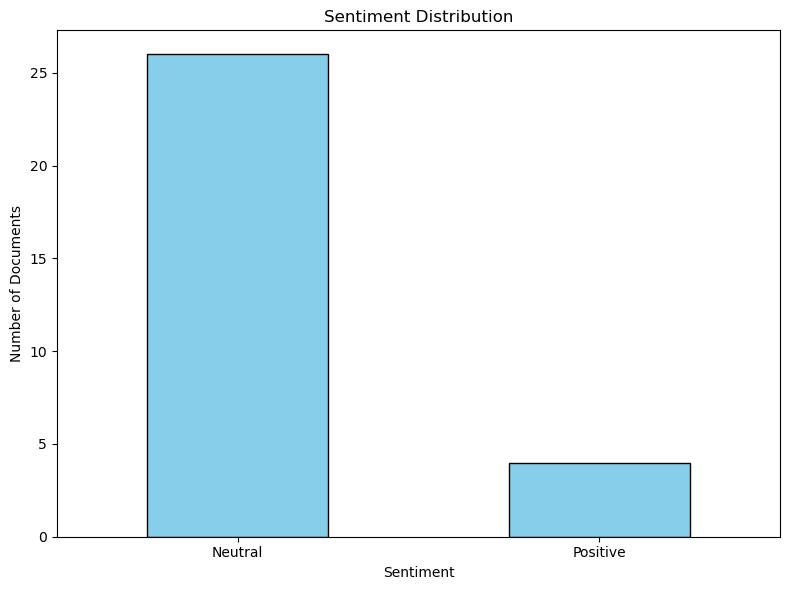

In [38]:
import matplotlib.pyplot as plt

# Sentiment distribution bar chart
plt.figure(figsize=(8, 6))
df_prepared['Sentiment'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Documents')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


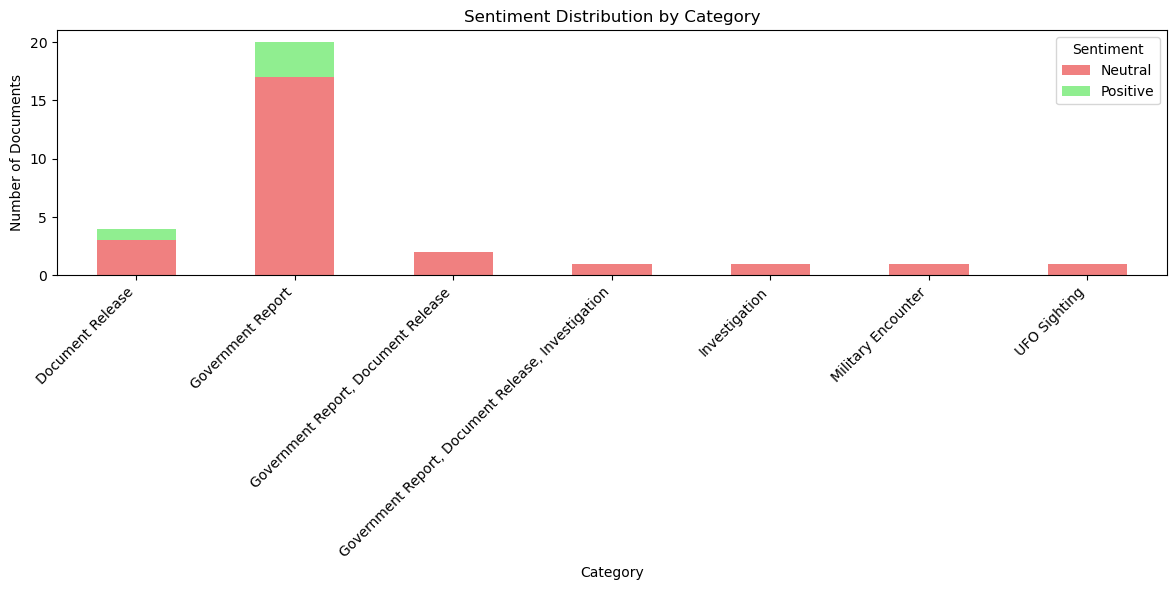

In [42]:
# Sentiment vs Categories (Stacked Bar Chart)
sentiment_category = pd.crosstab(df_prepared['Categories'], df_prepared['Sentiment'])

sentiment_category.plot(kind='bar', stacked=True, figsize=(12, 6), color=['lightcoral', 'lightgreen', 'skyblue'])
plt.title('Sentiment Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


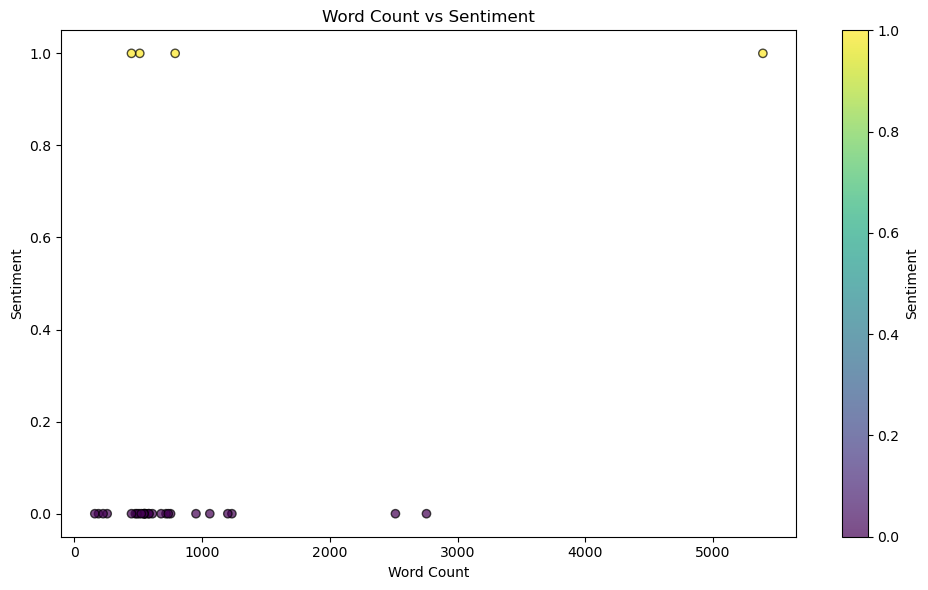

In [46]:
import matplotlib.pyplot as plt

# Map sentiments to numeric values
sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df_prepared['Sentiment Numeric'] = df_prepared['Sentiment'].map(sentiment_map)

# Word count vs Sentiment (Numeric)
plt.figure(figsize=(10, 6))
plt.scatter(df_prepared['Word Count'], df_prepared['Sentiment Numeric'], c=df_prepared['Sentiment Numeric'], cmap='viridis', alpha=0.7, edgecolor='black')
plt.title('Word Count vs Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Sentiment')
plt.colorbar(label='Sentiment')
plt.tight_layout()
plt.show()


##  RESULT
The Black Vault reveals a strong focus on government-related UFO documentation, with the majority of the articles—20 out of 30—categorized as government reports. These documents typically maintain a neutral tone, as reflected in the sentiment analysis, which shows 26 articles classified as neutral and only 4 as positive. This suggests that most of the content consists of factual, bureaucratic communication rather than speculative or opinionated writing. Common topics include the Pentagon’s clarification that AATIP wasn’t specifically about UFOs, an official debunking of the Aguadilla UFO incident as merely sky lanterns, and whistleblower activity involving figures like Luis Elizondo. These entries highlight a broader trend of the Department of Defense attempting to reframe or explain away past UFO narratives, possibly in response to growing congressional scrutiny and public interest. Although most articles fall under a single category, some also touch on military encounters, investigations, or direct UFO sightings, indicating occasional variety in content. Additionally, the wide range in word count—from short 161-word pieces to in-depth reports exceeding 5,000 words—suggests that the site hosts everything from brief memos to full-length FOIA document dumps. Overall, the dataset paints a picture of a platform focused on government transparency and the evolving official stance on unexplained aerial phenomena.